In [1]:
# Мы имеем задачу классификации текста, с которой должны 
# хорошо справляться rnn или lstm нейросети, однако на вебсайте 
# https://www.kaggle.com/competitions/swiss-dialect-identification/overview 
# посвященному этой задачке, указана ссылка на документаю scikit-learn
# что может быть намеком на линейную разделимость данных по классам
# ну или хотя бы на то что и без нейронок можно достичь хорошего результата
# так что попробуем решить задачу через logistic regression и tree of decisions

In [16]:
import csv

# loading some training data and deleting labels

data = []
labels = []

with open('data/swiss_dialect/train.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row[0])
        labels.append(row[1])
        
data.pop(0)
labels.pop(0)

testing_data = []
testing_labels = []

with open('data/swiss_dialect/test.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        testing_data.append(row[1])
        
testing_data.pop(0)

with open('data/swiss_dialect/test.GOLD.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        testing_labels.append(row[1])

testing_labels.pop(0)


print(f" Всего данных для обучения: {len(data)}, признаков: {len(labels)} ")
print(f" Тестовых данных: {len(testing_data)}, признаков: {len(testing_labels)} ")

 Всего данных для обучения: 15616, признаков: 15616 
 Тестовых данных: 2500, признаков: 2500 


In [18]:
# Преобразуем наши данные в формат bag of words
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()


train_data = vectorizer.fit_transform(data)
test_data = vectorizer.transform(testing_data)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_encoded_labels = label_encoder.fit_transform(labels)
test_encoded_labels = label_encoder.fit_transform(testing_labels)

train_labels = np.array(train_encoded_labels)
test_labels = np.array(test_encoded_labels)

train_1hot_labels = np.eye(4)[train_labels] # понадобится в будущем
test_1hot_labels = np.eye(4)[test_labels]


In [20]:
# первым делом проверим логистическую регрессию
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter = 10000)
lr.fit(train_data, train_labels)

test_pred = lr.predict(test_data)
train_pred = lr.predict(train_data)

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.8092
 Train Accuracy: 0.9583760245901639


Grid Search Results:
Mean Accuracy: 0.572 (±0.010) for {'C': 0.001}
Mean Accuracy: 0.680 (±0.012) for {'C': 0.01}
Mean Accuracy: 0.758 (±0.008) for {'C': 0.1}
Mean Accuracy: 0.793 (±0.011) for {'C': 1.0}
Mean Accuracy: 0.787 (±0.013) for {'C': 10.0}
Mean Accuracy: 0.764 (±0.019) for {'C': 100.0}
Mean Accuracy: 0.733 (±0.020) for {'C': 1000.0}


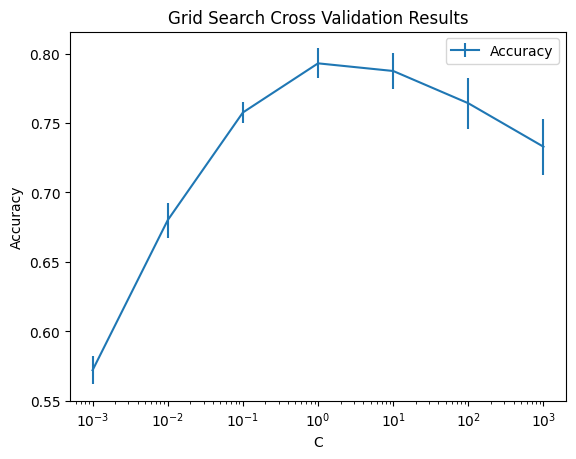

 Test Accuracy: 0.8092
 Train Accuracy: 0.9583760245901639


In [22]:
# оптимизируем гиперпараметры
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-3, 3, 7)}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=3)
grid_search.fit(train_data, train_labels)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

print("Grid Search Results:")
for mean, std, param in zip(means, stds, params):
    print(f"Mean Accuracy: {mean:.3f} (±{std * 2:.3f}) for {param}")

# построение графиков
plt.errorbar(param_grid['C'], means, yerr=stds * 2, label='Accuracy')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Grid Search Cross Validation Results')
plt.legend(loc='best')
plt.show()


# еще разок проверим 
optimised_lr = grid_search.best_estimator_

test_pred = optimised_lr.predict(test_data)
train_pred = optimised_lr.predict(train_data)

print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

In [23]:
# следующий вариант у нас на очереди это дерево решений
from sklearn.tree import DecisionTreeClassifier

# Инициализация и обучение модели
dt = DecisionTreeClassifier()
dt.fit(train_data, train_pred)

test_pred = dt.predict(test_data)
train_pred = dt.predict(train_data)

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.6484
 Train Accuracy: 0.9583760245901639


Grid Search Results:
Mean Accuracy: 0.353 (±0.006) for {'max_depth': 3, 'min_samples_split': 2}
Mean Accuracy: 0.353 (±0.006) for {'max_depth': 3, 'min_samples_split': 5}
Mean Accuracy: 0.353 (±0.005) for {'max_depth': 3, 'min_samples_split': 10}
Mean Accuracy: 0.402 (±0.005) for {'max_depth': 5, 'min_samples_split': 2}
Mean Accuracy: 0.402 (±0.006) for {'max_depth': 5, 'min_samples_split': 5}
Mean Accuracy: 0.402 (±0.005) for {'max_depth': 5, 'min_samples_split': 10}
Mean Accuracy: 0.428 (±0.007) for {'max_depth': 7, 'min_samples_split': 2}
Mean Accuracy: 0.428 (±0.007) for {'max_depth': 7, 'min_samples_split': 5}
Mean Accuracy: 0.428 (±0.007) for {'max_depth': 7, 'min_samples_split': 10}
Mean Accuracy: 0.465 (±0.004) for {'max_depth': 9, 'min_samples_split': 2}
Mean Accuracy: 0.464 (±0.004) for {'max_depth': 9, 'min_samples_split': 5}
Mean Accuracy: 0.465 (±0.003) for {'max_depth': 9, 'min_samples_split': 10}


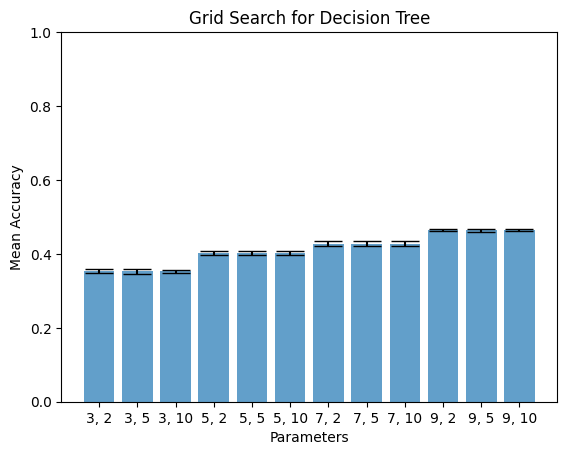

 Test Accuracy: 0.4692
 Train Accuracy: 0.4775870901639344


In [24]:
param_grid = {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)


grid_search.fit(train_data, train_labels)


means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']


print("Grid Search Results:")
for mean, std, param in zip(means, stds, params):
    print(f"Mean Accuracy: {mean:.3f} (±{std * 2:.3f}) for {param}")

# построение графиков
plt.figure()
plt.title('Grid Search for Decision Tree')
plt.xlabel('Parameters')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
param_combs = [f"{param['max_depth']}, {param['min_samples_split']}" for param in params]
plt.bar(param_combs, means, yerr=stds * 2, align='center', alpha=0.7, ecolor='black', capsize=10)
plt.show()

# еще разок проверим 
optimised_dt = grid_search.best_estimator_

test_pred = optimised_dt.predict(test_data)
train_pred = optimised_dt.predict(train_data)

print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

In [28]:
# теперь на очереди наивный баес
from sklearn.naive_bayes import GaussianNB

# Инициализация и обучение модели
NB = GaussianNB()
NB.fit(train_data.toarray(), train_pred)

test_pred = NB.predict(test_data.toarray())
train_pred = NB.predict(train_data.toarray())

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.4488
 Train Accuracy: 0.484375


In [29]:
# попробуем еще один формат для предобработки текста
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

train_data = tfidf_transformer.fit_transform(train_data)
test_data = tfidf_transformer.transform(test_data)

In [30]:
# повторим наши модели начиная с логистической регрессии
lr = LogisticRegression(max_iter = 10000)
lr.fit(train_data, train_labels)

test_pred = lr.predict(test_data)
train_pred = lr.predict(train_data)

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.8028
 Train Accuracy: 0.9266777663934426


Grid Search Results:
Mean Accuracy: 0.439 (±0.007) for {'C': 0.001}
Mean Accuracy: 0.590 (±0.011) for {'C': 0.01}
Mean Accuracy: 0.725 (±0.013) for {'C': 0.1}
Mean Accuracy: 0.791 (±0.006) for {'C': 1.0}
Mean Accuracy: 0.800 (±0.010) for {'C': 10.0}
Mean Accuracy: 0.783 (±0.019) for {'C': 100.0}
Mean Accuracy: 0.753 (±0.030) for {'C': 1000.0}


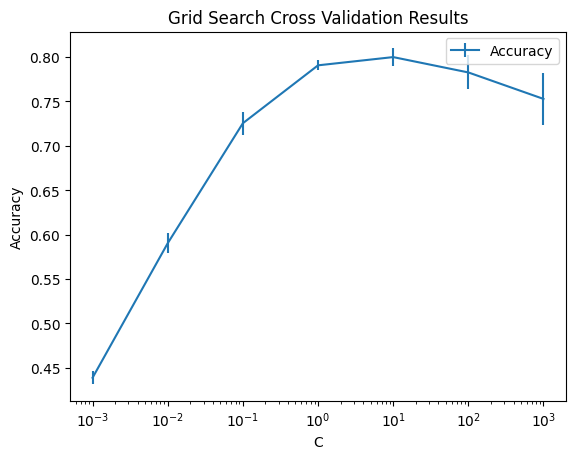

 Test Accuracy: 0.8232
 Train Accuracy: 0.9829661885245902


In [31]:
param_grid = {'C': np.logspace(-3, 3, 7)}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=3)
grid_search.fit(train_data, train_labels)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

print("Grid Search Results:")
for mean, std, param in zip(means, stds, params):
    print(f"Mean Accuracy: {mean:.3f} (±{std * 2:.3f}) for {param}")

# построение графиков
plt.errorbar(param_grid['C'], means, yerr=stds * 2, label='Accuracy')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Grid Search Cross Validation Results')
plt.legend(loc='best')
plt.show()


# еще разок проверим 
optimised_lr = grid_search.best_estimator_

test_pred = optimised_lr.predict(test_data)
train_pred = optimised_lr.predict(train_data)

print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

In [32]:
# decision tree
dt = DecisionTreeClassifier()
dt.fit(train_data, train_pred)

test_pred = dt.predict(test_data)
train_pred = dt.predict(train_data)

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.602
 Train Accuracy: 0.9829661885245902


Grid Search Results:
Mean Accuracy: 0.353 (±0.006) for {'max_depth': 3, 'min_samples_split': 2}
Mean Accuracy: 0.352 (±0.005) for {'max_depth': 3, 'min_samples_split': 5}
Mean Accuracy: 0.353 (±0.006) for {'max_depth': 3, 'min_samples_split': 10}
Mean Accuracy: 0.401 (±0.005) for {'max_depth': 5, 'min_samples_split': 2}
Mean Accuracy: 0.401 (±0.005) for {'max_depth': 5, 'min_samples_split': 5}
Mean Accuracy: 0.401 (±0.005) for {'max_depth': 5, 'min_samples_split': 10}
Mean Accuracy: 0.426 (±0.004) for {'max_depth': 7, 'min_samples_split': 2}
Mean Accuracy: 0.426 (±0.004) for {'max_depth': 7, 'min_samples_split': 5}
Mean Accuracy: 0.426 (±0.004) for {'max_depth': 7, 'min_samples_split': 10}
Mean Accuracy: 0.460 (±0.009) for {'max_depth': 9, 'min_samples_split': 2}
Mean Accuracy: 0.460 (±0.008) for {'max_depth': 9, 'min_samples_split': 5}
Mean Accuracy: 0.460 (±0.008) for {'max_depth': 9, 'min_samples_split': 10}


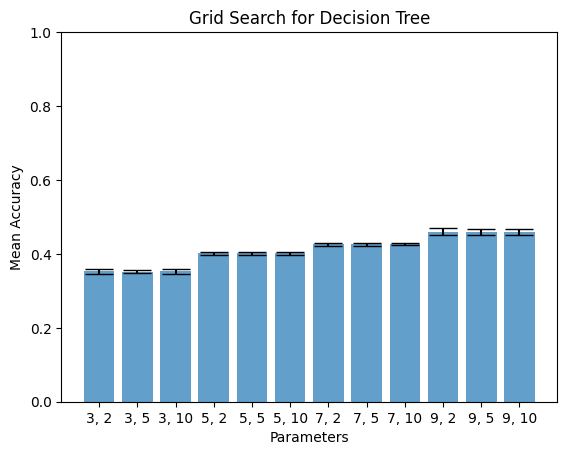

 Test Accuracy: 0.4664
 Train Accuracy: 0.4727843237704918


In [33]:
param_grid = {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)


grid_search.fit(train_data, train_labels)


means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']


print("Grid Search Results:")
for mean, std, param in zip(means, stds, params):
    print(f"Mean Accuracy: {mean:.3f} (±{std * 2:.3f}) for {param}")

# построение графиков
plt.figure()
plt.title('Grid Search for Decision Tree')
plt.xlabel('Parameters')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
param_combs = [f"{param['max_depth']}, {param['min_samples_split']}" for param in params]
plt.bar(param_combs, means, yerr=stds * 2, align='center', alpha=0.7, ecolor='black', capsize=10)
plt.show()

# еще разок проверим 
optimised_dt = grid_search.best_estimator_

test_pred = optimised_dt.predict(test_data)
train_pred = optimised_dt.predict(train_data)

print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

In [34]:
NB = GaussianNB()
NB.fit(train_data.toarray(), train_pred)

test_pred = NB.predict(test_data.toarray())
train_pred = NB.predict(train_data.toarray())

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.4504
 Train Accuracy: 0.49551741803278687


In [37]:
from sklearn.svm import SVC
# попробуем svc 

svc = SVC()
svc.fit(train_data, train_pred)

test_pred = svc.predict(test_data)
train_pred = svc.predict(train_data)

# Оценка модели
print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))

 Test Accuracy: 0.4828
 Train Accuracy: 0.5095414959016393


Grid Search Results:
Mean Accuracy: 0.637 (±0.011) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Mean Accuracy: 0.716 (±0.017) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Mean Accuracy: 0.470 (±0.012) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mean Accuracy: 0.716 (±0.017) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Mean Accuracy: 0.267 (±0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Accuracy: 0.716 (±0.017) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Mean Accuracy: 0.267 (±0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Mean Accuracy: 0.716 (±0.017) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Mean Accuracy: 0.794 (±0.014) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Mean Accuracy: 0.795 (±0.014) for {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Mean Accuracy: 0.746 (±0.022) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Mean Accuracy: 0.795 (±0.014) for {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Mean Accuracy: 0.508 (±0.008) for {'C': 1, 'gamma': 0.01, '

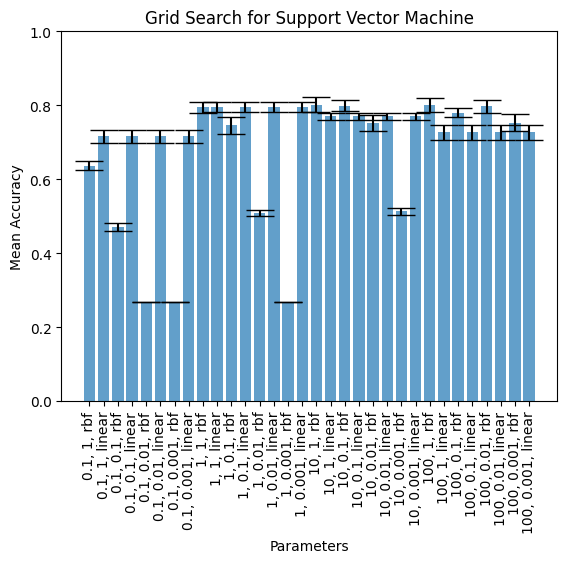

 Test Accuracy: 0.808
 Train Accuracy: 0.9964139344262295


In [38]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(train_data, train_labels)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# Вывод результатов
print("Grid Search Results:")
for mean, std, param in zip(means, stds, params):
    print(f"Mean Accuracy: {mean:.3f} (±{std * 2:.3f}) for {param}")

# Построение графиков
plt.figure()
plt.title('Grid Search for Support Vector Machine')
plt.xlabel('Parameters')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
param_combs = [f"{param['C']}, {param['gamma']}, {param['kernel']}" for param in params]
plt.bar(param_combs, means, yerr=stds * 2, align='center', alpha=0.7, ecolor='black', capsize=10)
plt.xticks(rotation=90)
plt.show()

optimised_svc = grid_search.best_estimator_

test_pred = optimised_svc.predict(test_data)
train_pred = optimised_svc.predict(train_data)

print(' Test Accuracy:', accuracy_score(test_labels, test_pred))
print(' Train Accuracy:', accuracy_score(train_labels, train_pred))